In [1]:
import os
import sys
import random
import re
import unicodedata
from pathlib import Path
from datetime import datetime
import json
import warnings

import pandas as pd
import numpy as np

# scikit-learn, joblib, plotting
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, precision_recall_fscore_support, confusion_matrix
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

# reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# silence warnings for notebook readability 
warnings.filterwarnings('ignore')

ROOT = Path.cwd()                     # notebook root
DATA_DIR = ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
MODELS_DIR = ROOT / "models"

TASKS_PATH = PROCESSED_DIR / "mslatte_tasks.txt"          # one sentence per line
QUESTIONS_PATH = PROCESSED_DIR / "msmarcosmall.txt"       # one sentence per line (large)
DEADLINES_SYNTH_PATH = PROCESSED_DIR / "synth_deadlines_rich.csv"  # generated synth CSV 

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

def quick_info(p: Path, show_head=False, head_lines=5):
    if not p.exists():
        return f"{str(p)} -> MISSING"
    try:
        sz = p.stat().st_size
    except Exception:
        sz = None
    info = f"{str(p)} -> EXISTS, size={sz} bytes"
    if show_head and p.is_file():
        try:
            with p.open('r', encoding='utf8', errors='ignore') as f:
                head = [next(f).rstrip() for _ in range(head_lines)]
            info += "\n  HEAD:\n    " + "\n    ".join(head)
        except StopIteration:
            pass
        except Exception as e:
            info += f"\n  HEAD ERROR: {e}"
    return info

# Print environment summary
print("Notebook root:", ROOT)
print("Python version:", sys.version.splitlines()[0])
print("\nPaths summary (change variables at top of cell if needed):")
print(" DATA_DIR:", DATA_DIR.exists(), DATA_DIR)
print(" RAW_DIR:", RAW_DIR.exists(), RAW_DIR)
print(" PROCESSED_DIR:", PROCESSED_DIR.exists(), PROCESSED_DIR)
print(" MODELS_DIR:", MODELS_DIR.exists(), MODELS_DIR)
print()
print(" TASKS file:", quick_info(TASKS_PATH, show_head=True))
print(" QUESTIONS file:", quick_info(QUESTIONS_PATH, show_head=True))
print(" SYNTH DEADLINES file:", quick_info(DEADLINES_SYNTH_PATH, show_head=True))

# Quick version checks 
print("\nLibrary versions:")
import sklearn, joblib, pandas, numpy
print(" scikit-learn:", sklearn.__version__)
print(" joblib:", joblib.__version__)
print(" pandas:", pandas.__version__)
print(" numpy:", numpy.__version__)

try:
    import psutil
    mem = psutil.virtual_memory()
    print(f"\nSystem memory: total={mem.total//(1024**3)} GB, available={mem.available//(1024**3)} GB")
except Exception:
    print("\npsutil not installed — skipped memory check (optional).")

# If everything imported & paths OK, create a small sentinel file in processed to mark progress.
sentinel = PROCESSED_DIR / "notebook_step0_ok.txt"
sentinel.write_text(f"Step0 ok at {datetime.now().isoformat()}\n", encoding='utf8')
print("\nWrote sentinel:", sentinel)

Notebook root: /home/tar_guest/BTH/note-processing
Python version: 3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]

Paths summary (change variables at top of cell if needed):
 DATA_DIR: True /home/tar_guest/BTH/note-processing/data
 RAW_DIR: True /home/tar_guest/BTH/note-processing/data/raw
 PROCESSED_DIR: True /home/tar_guest/BTH/note-processing/data/processed
 MODELS_DIR: True /home/tar_guest/BTH/note-processing/models

 TASKS file: /home/tar_guest/BTH/note-processing/data/processed/mslatte_tasks.txt -> EXISTS, size=161048 bytes
  HEAD:
    rearrange closet
    meeting tasks
    taste of home
    bring book in
    sociology paper
 QUESTIONS file: /home/tar_guest/BTH/note-processing/data/processed/msmarcosmall.txt -> EXISTS, size=29477367 bytes
  HEAD:
    $1000000 in 1994 monry
    $10,000 at 5% interest term deposit how much interest
    $128 usd to au
    $18,000 monthly in rent how much is building worth
    $195 australian dollars in pounds
 SYNTH DEADLINES file: /home/tar_gues

In [2]:
# STEP 1: Load sources, normalize, detect signoffs, and dedupe per-source
import re, unicodedata
from pathlib import Path

# Signoff detection patterns (conservative, common endings).
SIGNOFF_PATTERNS = [
    r'^\-+\s*[A-Za-z]{2,30}\s*$',   # "- Name" single token after dash
    r'\b(thanks|thank you|regards|best|cheers)\b[.,!]?$',  # end-of-line common words
]
SIGNOFF_RE = re.compile(r'(' + r'|'.join(SIGNOFF_PATTERNS) + r')', flags=re.I)

# Normalization regexes
_WS_RE = re.compile(r'\s+')
_TRIM_PUNCT_RE = re.compile(r'^[\W_]+|[\W_]+$')   # trim leading/trailing non-word characters

def normalize_text_for_model(s: str, strip_signoff: bool = True) -> str:
    """
    Produce a normalized string used for dedupe and TF-IDF training.
      - We keep sentence_orig unchanged for auditing; sentence_norm is used for dedupe & TF-IDF.
    """
    if s is None:
        s = ""
    s = str(s)
    # collapse newlines and whitespace
    s = s.replace('\r',' ').replace('\n',' ')
    s = _WS_RE.sub(' ', s).strip()
    # optionally strip signoff-like trailing fragments to avoid punctuation noise
    if strip_signoff:
        s = re.sub(r'(' + r'|'.join(SIGNOFF_PATTERNS) + r')\s*$', '', s, flags=re.I).strip()
    # unicode normalize and trim leading/trailing punctuation
    s = unicodedata.normalize('NFKC', s)
    s = _TRIM_PUNCT_RE.sub('', s).strip()
    s = _WS_RE.sub(' ', s)
    return s.lower()

def detect_has_signoff(s: str) -> bool:
    """Return True if a probable signoff is present at the end of the original line."""
    if s is None:
        return False
    s = str(s).replace('\r',' ').replace('\n',' ').strip()
    # check for signoff regex at end
    return bool(re.search(r'(' + r'|'.join(SIGNOFF_PATTERNS) + r')\s*$', s, flags=re.I))

def load_plain_text_lines(path: Path):
    with path.open('r', encoding='utf8', errors='ignore') as f:
        return [line.rstrip('\n') for line in f if line.strip()]

def load_csv_first_col(path: Path):
    # read csv and return first non-empty column as list of strings
    import pandas as pd
    df = pd.read_csv(path, dtype=str, keep_default_na=False)
    # prefer a column named 'sentence' if present
    candidates = ['sentence','text','content','note','body']
    for c in candidates:
        if c in df.columns:
            return df[c].astype(str).tolist()
    # otherwise return everything flattened (first column)
    return df.iloc[:,0].astype(str).tolist()

def load_source(path: Path):
    if not path.exists():
        print(f"WARNING: {path} not found. Returning empty list.")
        return []
    if path.suffix.lower() in ('.csv', '.tsv'):
        return load_csv_first_col(path)
    else:
        return load_plain_text_lines(path)

tasks_raw = load_source(Path(TASKS_PATH))
questions_raw = load_source(Path(QUESTIONS_PATH))
deadlines_raw = load_source(Path(DEADLINES_SYNTH_PATH))

print("Loaded counts (raw):")
print(" tasks:", len(tasks_raw))
print(" questions:", len(questions_raw))
print(" deadlines:", len(deadlines_raw))
print()

import pandas as pd
def build_df_from_list(lines, label, label_source):
    df = pd.DataFrame({'sentence_orig': [str(s) for s in lines]})
    # normalized for modeling (strip signoffs)
    df['sentence'] = df['sentence_orig'].apply(lambda s: normalize_text_for_model(s, strip_signoff=True))
    df['label'] = label
    df['label_source'] = label_source
    # signoff flag kept separately
    df['has_signoff'] = df['sentence_orig'].apply(detect_has_signoff).astype(int)
    return df

df_tasks = build_df_from_list(tasks_raw, 'task', 'mslatte')
df_questions = build_df_from_list(questions_raw, 'question', 'msmarco')
df_deadlines = build_df_from_list(deadlines_raw, 'deadline', 'synthetic')

def dedupe_per_source(df):
    before = len(df)
    df2 = df.drop_duplicates(subset=['sentence'], keep='first').reset_index(drop=True)
    after = len(df2)
    return df2, before, after

df_tasks_dedup, t_before, t_after = dedupe_per_source(df_tasks)
df_questions_dedup, q_before, q_after = dedupe_per_source(df_questions)
df_deadlines_dedup, d_before, d_after = dedupe_per_source(df_deadlines)

print("After per-source normalization & dedupe:")
print(f" tasks: {t_before} -> {t_after}")
print(f" questions: {q_before} -> {q_after}")
print(f" deadlines: {d_before} -> {d_after}")
print()

def diagnostics(df, name, n_samples=6):
    print(f"=== {name} (n={len(df)}) ===")
    print(" signoff fraction:", df['has_signoff'].mean())
    print(" sample normalized -> original (first", n_samples, "rows):")
    display(df[['sentence','sentence_orig','has_signoff']].head(n_samples))
    print()

diagnostics(df_tasks_dedup, "TASKS")
diagnostics(df_questions_dedup, "QUESTIONS")
diagnostics(df_deadlines_dedup, "DEADLINES")

processed_dir = Path("data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)
df_tasks_dedup.to_csv(processed_dir / "tasks_processed.csv", index=False, encoding='utf8')
df_questions_dedup.to_csv(processed_dir / "questions_processed.csv", index=False, encoding='utf8')
df_deadlines_dedup.to_csv(processed_dir / "deadlines_processed.csv", index=False, encoding='utf8')
print("Wrote processed CSVs to data/processed/: tasks_processed.csv, questions_processed.csv, deadlines_processed.csv")





Loaded counts (raw):
 tasks: 9997
 questions: 808731
 deadlines: 9449

After per-source normalization & dedupe:
 tasks: 9997 -> 9997
 questions: 808731 -> 806586
 deadlines: 9449 -> 9446

=== TASKS (n=9997) ===
 signoff fraction: 0.00020006001800540162
 sample normalized -> original (first 6 rows):


,sentence,sentence_orig,has_signoff
0,rearrange closet,rearrange closet,0
1,meeting tasks,meeting tasks,0
2,taste of home,taste of home,0
3,bring book in,bring book in,0
4,sociology paper,sociology paper,0
5,paper hold,paper hold,0



=== QUESTIONS (n=806586) ===
 signoff fraction: 0.0001351374806902178
 sample normalized -> original (first 6 rows):


,sentence,sentence_orig,has_signoff
0,1000000 in 1994 monry,$1000000 in 1994 monry,0
1,"10,000 at 5% interest term deposit how much in...","$10,000 at 5% interest term deposit how much i...",0
2,128 usd to au,$128 usd to au,0
3,"18,000 monthly in rent how much is building worth","$18,000 monthly in rent how much is building w...",0
4,195 australian dollars in pounds,$195 australian dollars in pounds,0
5,25 passage on a riverboat in the gold rush to ...,$25 passage on a riverboat in the gold rush to...,0



=== DEADLINES (n=9446) ===
 signoff fraction: 0.04583950878678806
 sample normalized -> original (first 6 rows):


,sentence,sentence_orig,has_signoff
0,"summary memo — until may 8, 2026 at noon","Summary memo — until May 8, 2026 at noon.",0
1,code fix - due january 25,code fix - due january 25.,0
2,complete the minutes required by friday at 2pm,Complete the minutes required by Friday at 2pm.,0
3,please post the slides in saturday,Please post the slides in Saturday.,0
4,"finish the budget deadline for january 26, 202...","Finish the budget deadline for January 26, 202...",0
5,minutes no later than march 17,Minutes no later than March 17.,0



Wrote processed CSVs to data/processed/: tasks_processed.csv, questions_processed.csv, deadlines_processed.csv


In [3]:
# STEP 2: Merge & balance dataset
import pandas as pd
from pathlib import Path
from collections import Counter
import json
from datetime import datetime
import re

PROCESSED_DIR = Path("data/processed")
OUT_COMBINED = PROCESSED_DIR / "combined_dataset.csv"
OUT_MANIFEST = PROCESSED_DIR / "combined_manifest.json"

# Preference order: if the same normalized sentence appears in multiple sources,
# the earlier source in this list is kept.
PREFERENCE_ORDER = ['task','deadline','question']

# minimal cleaning parameters
MIN_SENTENCE_CHARS = 3  
MIN_TOKEN_COUNT = 1       # drop empty token sentences

def load_processed(path: Path):
    if not path.exists():
        print(f"WARNING: {path} not found. Returning empty DataFrame.")
        return pd.DataFrame(columns=['sentence','sentence_orig','label','label_source','has_signoff'])
    df = pd.read_csv(path, dtype=str, keep_default_na=False)
    # ensure expected columns
    expected = ['sentence','sentence_orig','label','label_source','has_signoff']
    for c in expected:
        if c not in df.columns:
            # try to salvage: if sentence_orig missing but sentence exists, copy
            if c == 'sentence_orig' and 'sentence' in df.columns:
                df['sentence_orig'] = df['sentence']
            elif c == 'has_signoff':
                df['has_signoff'] = 0
            elif c == 'label':
                # if label not present, infer by filename
                inferred_label = 'unknown'
                if 'task' in path.name:
                    inferred_label = 'task'
                elif 'question' in path.name:
                    inferred_label = 'question'
                elif 'dead' in path.name:
                    inferred_label = 'deadline'
                df['label'] = inferred_label
            elif c == 'label_source':
                df['label_source'] = path.name
            else:
                df[c] = ''
    # ensure types
    df['has_signoff'] = df['has_signoff'].fillna('0').astype(int)
    return df[ ['sentence','sentence_orig','label','label_source','has_signoff'] ]

df_tasks = load_processed(PROCESSED_DIR / "tasks_processed.csv")
df_questions = load_processed(PROCESSED_DIR / "questions_processed.csv")
df_deadlines = load_processed(PROCESSED_DIR / "deadlines_processed.csv")

print("Loaded processed sources:")
print(" tasks:", len(df_tasks), "questions:", len(df_questions), "deadlines:", len(df_deadlines))

_ws_re = re.compile(r'\s+')
_trim_punct = re.compile(r'^[\W_]+|[\W_]+$')
def sanitize_norm(s):
    if pd.isna(s):
        return ''
    s = str(s)
    s = s.replace('\r',' ').replace('\n',' ')
    s = _ws_re.sub(' ', s).strip()
    s = _trim_punct.sub('', s)
    return s.lower()

for df in (df_tasks, df_questions, df_deadlines):
    df['sentence'] = df['sentence'].astype(str).apply(sanitize_norm)
    # drop blank sentences
    df.dropna(subset=['sentence'], inplace=True)
    df = df[df['sentence'].str.strip().astype(bool)]

# Combine with preference: iterate preference order and add unique normalized sentences
combined_map = {}   # sentence_norm -> dict(row)
sources_in_order = []
for label, df in [('task', df_tasks), ('deadline', df_deadlines), ('question', df_questions)]:
    sources_in_order.append((label, df))

for label, df in sources_in_order:
    # iterate rows and add if not present yet
    for idx, row in df.iterrows():
        s = row['sentence']
        if not s or len(s) < MIN_SENTENCE_CHARS:
            continue
        if s in combined_map:
            # already present from a preferred source; skip
            continue
        # keep provenance and original sentence
        combined_map[s] = {
            'sentence': s,
            'sentence_orig': row.get('sentence_orig', s),
            'label': row.get('label', label),
            'label_source': row.get('label_source', f"{label}_source"),
            'has_signoff': int(row.get('has_signoff', 0)),
            'provenance': row.get('label_source', f"{label}_source")
        }

# Build final DataFrame
combined_df = pd.DataFrame(list(combined_map.values()))
print("Combined unique sentences:", len(combined_df))

combined_df['token_count'] = combined_df['sentence'].apply(lambda s: len(s.split()))
combined_df = combined_df[combined_df['token_count'] >= MIN_TOKEN_COUNT].reset_index(drop=True)

# Diagnostics: class counts and basic stats
label_counts = combined_df['label'].value_counts().to_dict()
print("Label distribution after combine:", label_counts)

# Basic length stats
combined_df['char_len'] = combined_df['sentence'].str.len()
combined_df['word_count'] = combined_df['sentence'].str.split().str.len()
print("Char length mean:", combined_df['char_len'].mean(), "median:", combined_df['char_len'].median())

# Top n-grams per label quick diagnostic (uses simple frequency on tokens; not TF-IDF)
def top_ngrams_for_label(df, label, n=12, topk=12):
    sub = df[df['label']==label]
    tokens = sub['sentence'].str.split().explode()
    return tokens.value_counts().head(topk)

print("\nTop tokens per label (quick check):")
for lbl in combined_df['label'].unique():
    print("\nLabel:", lbl)
    print(top_ngrams_for_label(combined_df, lbl, topk=12).head(12))

# Print random samples per class for manual inspection
print("\nRandom samples per label (inspect these):")
for lbl in combined_df['label'].unique():
    print(f"\n--- SAMPLE for label {lbl} (n=10) ---")
    display(combined_df[combined_df['label']==lbl].sample(min(10, len(combined_df[combined_df['label']==lbl])), random_state=42)[['sentence_orig','sentence','label_source','has_signoff']])

# Save combined CSV and small manifest
combined_df.to_csv(OUT_COMBINED, index=False, encoding='utf8')
manifest = {
    'created': datetime.now().isoformat(),
    'combined_rows': len(combined_df),
    'label_counts': combined_df['label'].value_counts().to_dict(),
    'preference_order': PREFERENCE_ORDER,
    'sources': {
        'tasks_processed': len(df_tasks),
        'deadlines_processed': len(df_deadlines),
        'questions_processed': len(df_questions)
    }
}
with OUT_MANIFEST.open('w', encoding='utf8') as fh:
    json.dump(manifest, fh, indent=2)

print("\nWrote combined CSV:", OUT_COMBINED)
print("Wrote manifest JSON:", OUT_MANIFEST)



Loaded processed sources:
 tasks: 9997 questions: 806586 deadlines: 9446
Combined unique sentences: 826026
Label distribution after combine: {'question': 806584, 'task': 9996, 'deadline': 9446}
Char length mean: 35.16824409885403 median: 33.0

Top tokens per label (quick check):

Label: task
sentence
call     748
email    436
to       426
for      395
up       320
pay      275
get      269
buy      236
clean    202
check    194
book     190
order    171
Name: count, dtype: int64

Label: deadline
sentence
the         4547
due         3264
by          2909
in          2633
at          1924
deadline    1230
-           1174
2026        1133
notes        949
to           931
please       850
on           814
Name: count, dtype: int64

Label: question
sentence
what    291943
is      261924
the     176461
how     144792
of      131191
a       130984
in      117049
to      116411
does     73389
for      69914
do       46949
are      43131
Name: count, dtype: int64

Random samples per label (i

,sentence_orig,sentence,label_source,has_signoff
1078,excercise shorts,excercise shorts,mslatte,0
4336,resend invite,resend invite,mslatte,0
8966,upstairs bathroom fan,upstairs bathroom fan,mslatte,0
5456,fix timeline,fix timeline,mslatte,0
2407,shoulder massage,shoulder massage,mslatte,0
8995,go to all classes,go to all classes,mslatte,0
576,spanish hmwk,spanish hmwk,mslatte,0
7441,email about thesis,email about thesis,mslatte,0
5967,email about project,email about project,mslatte,0
439,pay phones,pay phones,mslatte,0



--- SAMPLE for label deadline (n=10) ---


,sentence_orig,sentence,label_source,has_signoff
14043,"Ensure the slides is due November 8, 2026 at 8pm.","ensure the slides is due november 8, 2026 at 8pm",synthetic,0
13551,"Hand in the evaluation required by March 7, 2026.","hand in the evaluation required by march 7, 2026",synthetic,0
10757,* Finish the assignment until next Thursday,finish the assignment until next thursday,synthetic,0
11466,• Return the project plan before this Sunday,return the project plan before this sunday,synthetic,0
11042,finish summary memo by this Friday,finish summary memo by this friday,synthetic,0
14292,implement release notes by April 23.,implement release notes by april 23,synthetic,0
18892,Make sure the presentation is before noon.,make sure the presentation is before noon,synthetic,0
13834,Please make sure to email the form deadline in...,please make sure to email the form deadline in...,synthetic,0
19347,expected by: summary memo in 180 days.,expected by: summary memo in 180 days,synthetic,0
16522,Ensure the application is due by Wednesday at ...,ensure the application is due by wednesday at 5pm,synthetic,0



--- SAMPLE for label question (n=10) ---


,sentence_orig,sentence,label_source,has_signoff
168424,hourly rate for pct in usa,hourly rate for pct in usa,msmarco,0
248557,how much does it cost to drive from ct to cali...,how much does it cost to drive from ct to cali...,msmarco,0
249398,how much does it cost to play paintball,how much does it cost to play paintball,msmarco,0
418322,urban definition slang for kutties,urban definition slang for kutties,msmarco,0
212867,how long is the gop going to take to stop trump,how long is the gop going to take to stop trump,msmarco,0
591950,what is medical credentialing definition,what is medical credentialing definition,msmarco,0
66429,can gums heal,can gums heal,msmarco,0
373824,"Plasmodium, the parasitic organism that causes...","plasmodium, the parasitic organism that causes...",msmarco,0
300082,how to spell veterinary,how to spell veterinary,msmarco,0
132007,does conduct heat,does conduct heat,msmarco,0



Wrote combined CSV: data/processed/combined_dataset.csv
Wrote manifest JSON: data/processed/combined_manifest.json


In [4]:
# STEP 3 rework too many features crashed the maxhine
import re, json
from pathlib import Path
from datetime import datetime
import numpy as np, pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import joblib

COMBINED_PATH = Path("data/processed/combined_dataset.csv")
MODELS_DIR = Path("models"); MODELS_DIR.mkdir(parents=True, exist_ok=True)
assert COMBINED_PATH.exists(), f"{COMBINED_PATH} missing"

df = pd.read_csv(COMBINED_PATH, dtype=str, keep_default_na=False)
sentences = df['sentence'].astype(str).tolist()
labels = df['label'].astype(str).tolist()
n = len(sentences)
print("Rows:", n)

WORD_NGRAM_RANGE = (1,3)
WORD_MAX_FEATURES = 100000   # reduced to be runnable
CHAR_NGRAM_RANGE = (3,5)
CHAR_MAX_FEATURES = 30000    # reduced
USE_CHAR = True              # set False to drop char features if memory still tight
TF_MIN_DF = 3
TF_MAX_DF = 0.995
CUE_VOCAB = [
    "deadline","due","no later than","due by","deadline for","by","before","until","on or before",
    "eod","cob","asap","tomorrow","today","next","in","at","before noon","due on","expected by","no later"
]

# Word TF-IDF
print("Fitting word TF-IDF (1-3 grams) max_features=%d..." % WORD_MAX_FEATURES)
tfidf_word = TfidfVectorizer(ngram_range=WORD_NGRAM_RANGE,
                             max_features=WORD_MAX_FEATURES,
                             min_df=TF_MIN_DF, max_df=TF_MAX_DF,
                             strip_accents='unicode', lowercase=True)
X_word = tfidf_word.fit_transform(sentences).astype(np.float32)
print(" X_word shape:", X_word.shape)

# Char TF-IDF
if USE_CHAR:
    print("Fitting char TF-IDF (char_wb 3-5 grams) max_features=%d..." % CHAR_MAX_FEATURES)
    tfidf_char = TfidfVectorizer(analyzer='char_wb', ngram_range=CHAR_NGRAM_RANGE,
                                 max_features=CHAR_MAX_FEATURES, min_df=TF_MIN_DF)
    X_char = tfidf_char.fit_transform(sentences).astype(np.float32)
    print(" X_char shape:", X_char.shape)
else:
    X_char = None

# cue presence binary
cue_vec = CountVectorizer(vocabulary=CUE_VOCAB, binary=True, lowercase=True)
X_cue = cue_vec.fit_transform(sentences).astype(np.float32)
print(" X_cue shape:", X_cue.shape)

# engineered features (concise but informative)
NUM_RE = re.compile(r'\d+')
WEEKDAY_RE = re.compile(r'\b(monday|tuesday|wednesday|thursday|friday|saturday|sunday)\b', re.I)
MONTH_RE = re.compile(r'\b(january|february|march|april|may|june|july|august|september|october|november|december)\b', re.I)
TIME_RE = re.compile(r'\b(?:\d{1,2}(:\d{2})?\s*(am|pm)|am|pm|noon|midnight|eod|cob)\b', re.I)
RELATIVE_RE = re.compile(r'\b(tomorrow|today|next|in\s+\d+\s+(?:day|days|week|weeks|month|months|hour|hours|minute|minutes))\b', re.I)
QUESTION_RE = re.compile(r'\?|\b(who|what|when|where|why|how|which)\b', re.I)
IMPERATIVE_RE = re.compile(r'^(submit|finish|complete|turn|send|email|deliver|make|do|create|update|fix|upload|prepare|post|hand in|return)\b', re.I)
DURATION_RE = re.compile(r'\b(hour|hours|minute|minutes|day|days|week|weeks|month|months|year|years)\b', re.I)
CURRENCY_RE = re.compile(r'[$£€¥]|usd|aud|gbp|cad', re.I)
URL_EMAIL_RE = re.compile(r'http[s]?://|www\.|@', re.I)
PUNCT_Q = re.compile(r'\?')

def engineered_array(sent_list):
    rows=[]
    for s in sent_list:
        sl = s.lower()
        tokens = sl.split()
        tc = max(1, len(tokens))
        num_digits = 1 if NUM_RE.search(sl) else 0
        has_weekday = 1 if WEEKDAY_RE.search(sl) else 0
        has_month = 1 if MONTH_RE.search(sl) else 0
        has_time = 1 if TIME_RE.search(sl) else 0
        has_relative = 1 if RELATIVE_RE.search(sl) else 0
        has_question = 1 if QUESTION_RE.search(sl) else 0
        starts_imp = 1 if IMPERATIVE_RE.match(sl) else 0
        has_duration = 1 if DURATION_RE.search(sl) else 0
        has_currency = 1 if CURRENCY_RE.search(sl) else 0
        has_url_email = 1 if URL_EMAIL_RE.search(sl) else 0
        q_marks = len(PUNCT_Q.findall(sl))
        avg_token_len = float(sum(len(t) for t in tokens) / tc)
        unique_ratio = float(len(set(tokens)) / tc)
        numeric_ratio = float(sum(1 for t in tokens if NUM_RE.fullmatch(t)) / tc)
        rows.append([
            tc, avg_token_len, unique_ratio, numeric_ratio,
            num_digits, has_weekday, has_month, has_time, has_relative, has_duration,
            has_question, starts_imp, has_currency, has_url_email, q_marks
        ])
    return np.array(rows, dtype=float)

print("Extracting engineered features...")
X_eng = engineered_array(sentences)
X_eng_sparse = csr_matrix(X_eng)

# combine sparse parts
parts = [X_word]
if USE_CHAR and X_char is not None:
    parts.append(X_char)
parts.append(X_cue)
parts.append(X_eng_sparse)
X_all = hstack(parts, format='csr')
print("Final combined X_all shape:", X_all.shape)

# save artifacts
joblib.dump(tfidf_word, MODELS_DIR / "tfidf_word_adj.joblib", compress=3)
if USE_CHAR and X_char is not None:
    joblib.dump(tfidf_char, MODELS_DIR / "tfidf_char_adj.joblib", compress=3)
joblib.dump(cue_vec, MODELS_DIR / "cue_vec_adj.joblib", compress=3)
meta = {
    'created': datetime.now().isoformat(),
    'n_examples': n,
    'word_max_features': WORD_MAX_FEATURES,
    'char_max_features': CHAR_MAX_FEATURES if USE_CHAR else 0,
    'engineered_feature_count': X_eng.shape[1],
    'engineered_feature_names': [
        'token_count','avg_token_len','unique_ratio','numeric_ratio',
        'has_digit','has_weekday','has_month','has_time','has_relative','has_duration',
        'has_question','starts_imperative','has_currency','has_url_email','q_marks'
    ]
}
with open(MODELS_DIR / "feature_metadata_adj.json", "w", encoding="utf8") as fh:
    json.dump(meta, fh, indent=2)

print("Saved adjusted vectorizers & metadata. X_all ready for training.")
# expose X_all, labels
X_all, labels = X_all, np.array(labels)


Rows: 826026
Fitting word TF-IDF (1-3 grams) max_features=100000...
 X_word shape: (826026, 100000)
Fitting char TF-IDF (char_wb 3-5 grams) max_features=30000...
 X_char shape: (826026, 30000)
 X_cue shape: (826026, 21)
Extracting engineered features...
Final combined X_all shape: (826026, 130036)
Saved adjusted vectorizers & metadata. X_all ready for training.


Train/Calib/Test sizes: 660820 82603 82603
Training LinearSVC (GridSearchCV with cv=3)...
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/home/tar_guest/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/tar_guest/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/tar_guest/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/tar_guest/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/tar_gu

SVC trained. Best params: {'C': 1.0}
Calibrating (prefit) on calibration set...
Calibrator saved.
Classification report (test):
              precision    recall  f1-score   support

    deadline     0.9979    1.0000    0.9989       945
    question     0.9986    0.9991    0.9988     80659
        task     0.9236    0.8829    0.9028       999

    accuracy                         0.9977     82603
   macro avg     0.9733    0.9607    0.9668     82603
weighted avg     0.9976    0.9977    0.9977     82603

Macro-F1: 0.9668388645008551


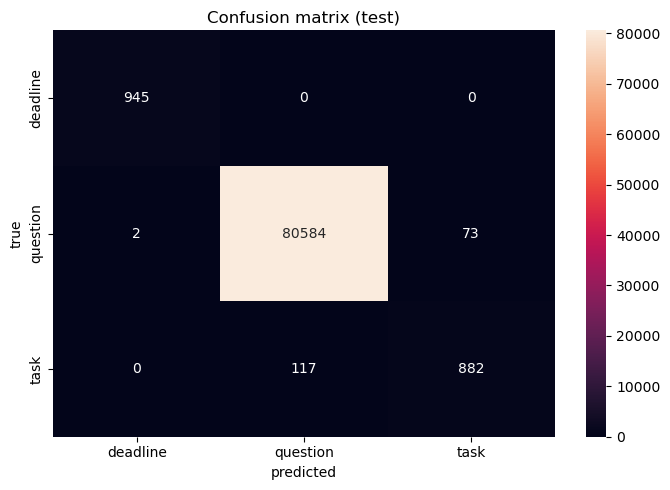

SENT: when was princess calla born
 PRED: question  TRUE: question  FLAG_POSSIBLE_DEADLINE? False
 PROBS: {'deadline': 0.0, 'question': 1.0, 'task': 0.0}
--------------------------------------------------------------------------------
SENT: hurst definition
 PRED: question  TRUE: question  FLAG_POSSIBLE_DEADLINE? False
 PROBS: {'deadline': 0.0, 'question': 1.0, 'task': 0.0}
--------------------------------------------------------------------------------
SENT: what is degree of licenses and science?
 PRED: question  TRUE: question  FLAG_POSSIBLE_DEADLINE? False
 PROBS: {'deadline': 0.0, 'question': 1.0, 'task': 0.0}
--------------------------------------------------------------------------------
SENT: what does anti money laundering mean
 PRED: question  TRUE: question  FLAG_POSSIBLE_DEADLINE? False
 PROBS: {'deadline': 0.0, 'question': 1.0, 'task': 0.0}
--------------------------------------------------------------------------------
SENT: how much does rgis pay
 PRED: question  TRUE: q

In [5]:
# STEP 4 (ADJUSTED): train LinearSVC on train set; calibrate (prefit) on a smaller calibration set; fallback to SGD if SVC OOMs.
import numpy as np, joblib, json, traceback
from pathlib import Path
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt, seaborn as sns

OUT = Path("models")
OUT.mkdir(parents=True, exist_ok=True)

# options tuned to be practical
CALIBRATE = True
TEST_SIZE = 0.10
CALIB_SIZE = 0.10   # calibration set size (of whole)
RND = 42
C_GRID = [0.1, 1.0]  # small grid
CV_FOLDS = 3

assert 'X_all' in globals() and 'labels' in globals(), "Run STEP 3 adjusted first."

y = np.array(labels)
idx = np.arange(X_all.shape[0])
train_idx, temp_idx, y_train, y_temp = train_test_split(idx, y, test_size=(TEST_SIZE + CALIB_SIZE), stratify=y, random_state=RND)
calib_frac_of_temp = CALIB_SIZE / (TEST_SIZE + CALIB_SIZE)
calib_idx, test_idx, y_calib, y_test = train_test_split(temp_idx, y_temp, test_size=(1-calib_frac_of_temp), stratify=y_temp, random_state=RND)

print("Train/Calib/Test sizes:", len(train_idx), len(calib_idx), len(test_idx))

X_train = X_all[train_idx]
X_calib  = X_all[calib_idx]
X_test   = X_all[test_idx]

svc_model = None
calibrator = None
trained_with = None

try:
    print("Training LinearSVC (GridSearchCV with cv=%d)..." % CV_FOLDS)
    svc = LinearSVC(class_weight='balanced', max_iter=20000)
    grid = GridSearchCV(svc, {'C': C_GRID}, scoring='f1_macro', cv=CV_FOLDS, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    svc_model = grid.best_estimator_
    trained_with = 'svc'
    joblib.dump(svc_model, OUT / "svc_adj.joblib", compress=3)
    print("SVC trained. Best params:", grid.best_params_)
    # calibrate if requested
    if CALIBRATE:
        print("Calibrating (prefit) on calibration set...")
        calibrator = CalibratedClassifierCV(svc_model, method='sigmoid', cv='prefit')
        calibrator.fit(X_calib, y_calib)
        joblib.dump(calibrator, OUT / "svc_calibrated_adj.joblib", compress=3)
        print("Calibrator saved.")
except Exception as e:
    print("SVC failed or OOM. Falling back to SGD partial_fit. Exception:")
    traceback.print_exc()
    trained_with = 'sgd'
    # incremental SGD training over shuffled data
    from sklearn.linear_model import SGDClassifier
    classes = np.unique(y)
    sgd = SGDClassifier(loss='hinge', class_weight='balanced', random_state=RND)
    chunk_size = 50000  # reduce if still heavy
    order = np.arange(X_all.shape[0])
    np.random.seed(RND)
    np.random.shuffle(order)
    for start in range(0, X_all.shape[0], chunk_size):
        batch_idx = order[start:start+chunk_size]
        Xb = X_all[batch_idx]
        yb = y[batch_idx]
        if start == 0:
            sgd.partial_fit(Xb, yb, classes=classes)
        else:
            sgd.partial_fit(Xb, yb)
        print(" Trained chunk", start, "->", start+len(batch_idx))
    svc_model = sgd
    joblib.dump(svc_model, OUT / "sgd_partial_adj.joblib", compress=3)
    print("SGD fallback model saved. Skipping calibration for fallback.")

# Evaluate
if calibrator is not None:
    y_pred = calibrator.predict(X_test)
    y_proba = calibrator.predict_proba(X_test)
else:
    y_pred = svc_model.predict(X_test)
    y_proba = None

print("Classification report (test):")
print(classification_report(y_test, y_pred, digits=4))
print("Macro-F1:", f1_score(y_test, y_pred, average='macro'))

# confusion matrix
labels_unique = sorted(np.unique(y))
cm = confusion_matrix(y_test, y_pred, labels=labels_unique)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_unique, yticklabels=labels_unique)
plt.xlabel('predicted'); plt.ylabel('true'); plt.title('Confusion matrix (test)')
plt.tight_layout()
plt.savefig(OUT / "confusion_adj.png", dpi=150)
plt.show()

# show some sample predictions with confidences (if available) and the task->deadline check
import random, re
WEEKDAY_RE = re.compile(r'\b(monday|tuesday|wednesday|thursday|friday|saturday|sunday)\b', re.I)
MONTH_RE = re.compile(r'\b(january|february|march|april|may|june|july|august|september|october|november|december)\b', re.I)
TIME_RE = re.compile(r'\b(?:\d{1,2}(:\d{2})?\s*(am|pm)|am|pm|noon|midnight|eod|cob)\b', re.I)
RELATIVE_RE = re.compile(r'\b(tomorrow|today|next|in\s+\d+\s+(?:day|days|week|weeks|month|months|hour|hours|minute|minutes))\b', re.I)
NUM_RE = re.compile(r'\d+')

def has_date_like(s):
    sl = s.lower()
    return bool(WEEKDAY_RE.search(sl) or MONTH_RE.search(sl) or TIME_RE.search(sl) or RELATIVE_RE.search(sl) or NUM_RE.search(sl))

rnd = random.Random(RND)
sample_test_idx = rnd.sample(list(test_idx), min(20, len(test_idx)))
for idx0 in sample_test_idx:
    sent_orig = df.iloc[idx0]['sentence_orig'] if 'sentence_orig' in df.columns else df.iloc[idx0]['sentence']
    sent_norm = df.iloc[idx0]['sentence']
    true_label = df.iloc[idx0]['label']
    if y_proba is not None:
        proba = calibrator.predict_proba(X_all[idx0])
        probs = dict(zip(calibrator.classes_.tolist(), proba.flatten().round(4).tolist()))
        pred_label = max(probs.items(), key=lambda x: x[1])[0]
    else:
        pred_label = svc_model.predict(X_all[idx0])[0]
        probs = None
    flag_dead = (pred_label=='task') and has_date_like(sent_norm)
    print("SENT:", sent_orig)
    print(" PRED:", pred_label, " TRUE:", true_label, " FLAG_POSSIBLE_DEADLINE?", flag_dead)
    if probs is not None:
        print(" PROBS:", probs)
    print("-"*80)

# save training manifest
manifest = {
    'trained_with': trained_with,
    'calibrated': bool(calibrator is not None),
    'created': datetime.now().isoformat()
}
with open(OUT / "train_manifest_adj.json", "w", encoding="utf8") as fh:
    json.dump(manifest, fh, indent=2)

print("Training complete. Artifacts saved to models/.")


In [6]:
# STEP 5: Targeted error analysis for the 'task' class (run after Step 4)
import joblib, json, re, numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

MODELS_DIR = Path("models")
OUT_FN_CSV = MODELS_DIR / "task_false_negatives.csv"
OUT_FP_CSV = MODELS_DIR / "task_false_positives.csv"

# load combined df
DF_PATH = Path("data/processed/combined_dataset.csv")
df = pd.read_csv(DF_PATH, dtype=str, keep_default_na=False)
n = len(df)
print("Loaded combined df rows:", n)

try:
    X_all  # noqa: F821
    labels  # noqa: F821
except NameError:
    raise RuntimeError("X_all and labels not found in notebook. Re-run Step 3 adjusted to produce X_all and labels in the notebook namespace.")

cal = None
svc = None
if (MODELS_DIR / "svc_calibrated_adj.joblib").exists():
    try:
        cal = joblib.load(MODELS_DIR / "svc_calibrated_adj.joblib")
        print("Loaded calibrated classifier:", "svc_calibrated_adj.joblib")
    except Exception:
        cal = None
if cal is None and (MODELS_DIR / "svc_adj.joblib").exists():
    svc = joblib.load(MODELS_DIR / "svc_adj.joblib")
    print("Loaded SVC (no calibrator): svc_adj.joblib")
elif cal is None and svc is None:
    # try other names
    if (MODELS_DIR / "svc_trained_on_train.joblib").exists():
        svc = joblib.load(MODELS_DIR / "svc_trained_on_train.joblib")
        print("Loaded SVC svc_trained_on_train.joblib")

RND = 42
TEST_SIZE = 0.10
CALIB_SIZE = 0.10
y = np.array(labels)
idx = np.arange(len(y))
train_idx, temp_idx, _, _ = train_test_split(idx, y, test_size=(TEST_SIZE + CALIB_SIZE), stratify=y, random_state=RND)
calib_frac_of_temp = CALIB_SIZE / (TEST_SIZE + CALIB_SIZE)
calib_idx, test_idx, _, _ = train_test_split(temp_idx, y[temp_idx], test_size=(1-calib_frac_of_temp), stratify=y[temp_idx], random_state=RND)

print("Using test set size:", len(test_idx))

# Predict on test set
if cal is not None:
    y_pred = cal.predict(X_all[test_idx])
    try:
        y_proba = cal.predict_proba(X_all[test_idx])
    except Exception:
        y_proba = None
else:
    y_pred = svc.predict(X_all[test_idx])
    y_proba = None

y_true = y[test_idx]

# Basic metrics & confusion
print("\nClassification report (test):")
print(classification_report(y_true, y_pred, digits=4))
labels_unique = sorted(list(set(y)))
cm = confusion_matrix(y_true, y_pred, labels=labels_unique)
print("Confusion matrix labels:", labels_unique)
print(cm)

test_df = df.iloc[test_idx].copy().reset_index(drop=True)
test_df['true'] = y_true
test_df['pred'] = y_pred

fn = test_df[(test_df['true']=='task') & (test_df['pred']!='task')].copy()
fp = test_df[(test_df['pred']=='task') & (test_df['true']!='task')].copy()
print(f"\nTask false negatives (true=task but pred!=task): {len(fn)}")
print(f"Task false positives (pred=task but true!=task): {len(fp)}")

# Save CSVs for manual inspection
fn.to_csv(OUT_FN_CSV, index=False, encoding='utf8')
fp.to_csv(OUT_FP_CSV, index=False, encoding='utf8')
print(f"Saved FN examples -> {OUT_FN_CSV}")
print(f"Saved FP examples -> {OUT_FP_CSV}")

# Show representative samples (up to 40 each)
def show_sample(df_sub, n=20, title="Samples"):
    print(f"\n{title} (showing up to {n} examples):")
    display(df_sub[['sentence_orig','sentence','true','pred','label_source']].head(n))

show_sample(fn.sample(min(40, len(fn)), random_state=RND) if len(fn)>0 else fn, n=40, title="Task FALSE NEGATIVES")
show_sample(fp.sample(min(40, len(fp)), random_state=RND) if len(fp)>0 else fp, n=40, title="Task FALSE POSITIVES")

def top_tokens(series, topk=30):
    from collections import Counter
    c = Counter()
    for s in series:
        for t in s.split():
            c[t] += 1
    return c.most_common(topk)

if len(fn) > 0:
    print("\nTop tokens in Task FALSE NEGATIVES:")
    print(top_tokens(fn['sentence'].tolist(), topk=30))
if len(fp) > 0:
    print("\nTop tokens in Task FALSE POSITIVES:")
    print(top_tokens(fp['sentence'].tolist(), topk=30))

# Date-like detection for tasks (so you can flag/move to deadlines)
WEEKDAY_RE = re.compile(r'\b(monday|tuesday|wednesday|thursday|friday|saturday|sunday)\b', re.I)
MONTH_RE = re.compile(r'\b(january|february|march|april|may|june|july|august|september|october|november|december)\b', re.I)
TIME_RE = re.compile(r'\b(?:\d{1,2}(:\d{2})?\s*(am|pm)|am|pm|noon|midnight|eod|cob)\b', re.I)
RELATIVE_RE = re.compile(r'\b(tomorrow|today|next|in\s+\d+\s+(?:day|days|week|weeks|month|months|hour|hours|minute|minutes))\b', re.I)
NUM_RE = re.compile(r'\d+')

def has_date_like(s):
    sl = s.lower()
    return bool(WEEKDAY_RE.search(sl) or MONTH_RE.search(sl) or TIME_RE.search(sl) or RELATIVE_RE.search(sl) or NUM_RE.search(sl))

# For false negatives: how many were actually date-like? (helps to know if they should be deadlines)
if len(fn)>0:
    fn['has_date_like'] = fn['sentence'].apply(has_date_like).astype(int)
    print("\nFalse negatives with date-like tokens:", int(fn['has_date_like'].sum()), "/", len(fn))
    display(fn[fn['has_date_like']==1].sample(min(20, fn['has_date_like'].sum()), random_state=RND)[['sentence_orig','sentence','true','pred']])

# For predicted tasks (FPs): how many are questions/deadlines mis-predicted as tasks?
if len(fp)>0:
    print("\nFP class distribution (what true classes were predicted as task?):")
    print(fp['true'].value_counts().to_dict())
    fp['has_date_like'] = fp['sentence'].apply(has_date_like).astype(int)
    print("FPs containing date-like tokens:", int(fp['has_date_like'].sum()), "/", len(fp))
    display(fp.sample(min(20, len(fp)), random_state=RND)[['sentence_orig','sentence','true','pred']])

# Feature-level insight: top tokens contributing to 'task' class (requires vectorizers & saved metadata)
print("\nAttempting to show top feature tokens for 'task' class (if vectorizers available)...")
feat_names = []
try:
    # load vectorizers that were used in STEP 3 adjusted
    tf_word = joblib.load(MODELS_DIR / "tfidf_word_adj.joblib")
    tf_char = joblib.load(MODELS_DIR / "tfidf_char_adj.joblib") if (MODELS_DIR / "tfidf_char_adj.joblib").exists() else None
    cue_vec = joblib.load(MODELS_DIR / "cue_vec_adj.joblib") if (MODELS_DIR / "cue_vec_adj.joblib").exists() else None
    meta = json.load(open(MODELS_DIR / "feature_metadata_adj.json", 'r', encoding='utf8')) if (MODELS_DIR / "feature_metadata_adj.json").exists() else None

    # build feature name list in same order as X_all stacking (word, char, cue, engineered)
    # word features:
    inv_word = {v:k for k,v in tf_word.vocabulary_.items()}
    word_dim = len(inv_word)
    word_names = [inv_word.get(i, f"word_{i}") for i in range(word_dim)]

    char_names = []
    if tf_char is not None:
        inv_char = {v:k for k,v in tf_char.vocabulary_.items()}
        char_dim = len(inv_char)
        char_names = [inv_char.get(i, f"char_{i}") for i in range(char_dim)]

    cue_names = cue_vec.get_feature_names_out().tolist() if cue_vec is not None else []

    eng_names = meta['engineered_feature_names'] if meta and 'engineered_feature_names' in meta else ['eng_%d' % i for i in range(20)]

    feat_names = word_names + char_names + cue_names + eng_names

    # load SVC coefficients: prefer calibrated wrapper's base_estimator else svc file
    if cal is not None:
        base = cal.base_estimator
    else:
        base = svc
    coefs = base.coef_  # shape (n_classes, n_features)
    classes = base.classes_
    # find index of 'task' class
    idx_task = list(classes).index('task')
    task_coefs = coefs[idx_task]
    # top positive features pushing toward 'task'
    top_pos_idx = np.argsort(task_coefs)[-40:][::-1]
    top_neg_idx = np.argsort(task_coefs)[:40]
    print("\nTop positive features for 'task' (tokens/engineered features):")
    for i in top_pos_idx[:40]:
        name = feat_names[i] if i < len(feat_names) else f"f_{i}"
        print(i, name, float(task_coefs[i]))
    print("\nTop negative features (push away from 'task'):")
    for i in top_neg_idx[:40]:
        name = feat_names[i] if i < len(feat_names) else f"f_{i}"
        print(i, name, float(task_coefs[i]))

except Exception as e:
    print("Could not show detailed feature tokens (missing vectorizers/metadata or mismatch). Error:", e)



Loaded combined df rows: 826026
Loaded calibrated classifier: svc_calibrated_adj.joblib
Using test set size: 82603

Classification report (test):
              precision    recall  f1-score   support

    deadline     0.9979    1.0000    0.9989       945
    question     0.9986    0.9991    0.9988     80659
        task     0.9236    0.8829    0.9028       999

    accuracy                         0.9977     82603
   macro avg     0.9733    0.9607    0.9668     82603
weighted avg     0.9976    0.9977    0.9977     82603

Confusion matrix labels: ['deadline', 'question', 'task']
[[  945     0     0]
 [    2 80584    73]
 [    0   117   882]]

Task false negatives (true=task but pred!=task): 117
Task false positives (pred=task but true!=task): 73
Saved FN examples -> models/task_false_negatives.csv
Saved FP examples -> models/task_false_positives.csv

Task FALSE NEGATIVES (showing up to 40 examples):


,sentence_orig,sentence,true,pred,label_source
27394,deepika cider vinegar,deepika cider vinegar,task,question,mslatte
2283,food handler card,food handler card,task,question,mslatte
34616,garlic oil,garlic oil,task,question,mslatte
25630,make chrome default browser,make chrome default browser,task,question,mslatte
6132,language test,language test,task,question,mslatte
56799,pharmacademic,pharmacademic,task,question,mslatte
48487,recite holy quran,recite holy quran,task,question,mslatte
64412,razors,razors,task,question,mslatte
24153,whole wheat spiral pasta,whole wheat spiral pasta,task,question,mslatte
7953,buy curtains and curtain rod,buy curtains and curtain rod,task,question,mslatte



Task FALSE POSITIVES (showing up to 40 examples):


,sentence_orig,sentence,true,pred,label_source
2996,pay credit card costco,pay credit card costco,question,task,msmarco
76351,amcpx dividends,amcpx dividends,question,task,msmarco
21581,feet cracked,feet cracked,question,task,msmarco
1323,reduce morning eye redness,reduce morning eye redness,question,task,msmarco
32509,internet fax,internet fax,question,task,msmarco
81897,pay for speeding ticket,pay for speeding ticket,question,task,msmarco
11320,tryptophan turns into,tryptophan turns into,question,task,msmarco
39514,pa dmv contact,pa dmv contact,question,task,msmarco
12256,the donut store,the donut store,question,task,msmarco
66321,cgview server,cgview server,question,task,msmarco



Top tokens in Task FALSE NEGATIVES:
[('to', 7), ('of', 6), ('change', 4), ('do', 3), ('card', 3), ('buy', 3), ('and', 3), ('on', 3), ('make', 3), ('cider', 2), ('vinegar', 2), ('install', 2), ('carbon', 2), ('monoxide', 2), ('amazon', 2), ('barclays', 2), ('debit', 2), ('address', 2), ('chrome', 2), ('for', 2), ('in', 2), ('detectors', 2), ('dishes', 2), ('dishwasher', 2), ('schedule', 2), ('exercises', 2), ('the', 2), ('system', 2), ('take', 2), ('canadian', 1)]

Top tokens in Task FALSE POSITIVES:
[('pay', 5), ('for', 4), ('test', 3), ('accounting', 2), ('insurance', 2), ('in', 2), ('a', 2), ('stand', 2), ('the', 2), ('tsa', 2), ('payment', 2), ('forms', 2), ('of', 2), ('reduce', 1), ('morning', 1), ('eye', 1), ('redness', 1), ('cover', 1), ('letter', 1), ('crm', 1), ('earth', 1), ('day', 1), ('shirt', 1), ('credit', 1), ('card', 1), ('costco', 1), ('skype', 1), ('powershell', 1), ('hat', 1), ('bag', 1)]

False negatives with date-like tokens: 2 / 117


,sentence_orig,sentence,true,pred
65816,next weeks menu,next weeks menu,task,question
55050,18 min cardio,18 min cardio,task,question



FP class distribution (what true classes were predicted as task?):
{'question': 73}
FPs containing date-like tokens: 3 / 73


,sentence_orig,sentence,true,pred
2996,pay credit card costco,pay credit card costco,question,task
76351,amcpx dividends,amcpx dividends,question,task
21581,feet cracked,feet cracked,question,task
1323,reduce morning eye redness,reduce morning eye redness,question,task
32509,internet fax,internet fax,question,task
81897,pay for speeding ticket,pay for speeding ticket,question,task
11320,tryptophan turns into,tryptophan turns into,question,task
39514,pa dmv contact,pa dmv contact,question,task
12256,the donut store,the donut store,question,task
66321,cgview server,cgview server,question,task



Attempting to show top feature tokens for 'task' class (if vectorizers available)...
Could not show detailed feature tokens (missing vectorizers/metadata or mismatch). Error: 'CalibratedClassifierCV' object has no attribute 'base_estimator'


In [9]:
# FINAL INFERENCE & EXPORT 
# - Uses calibrated classifier if available
# Predicts on sample (5k) and saves CSV to models/final_predictions_after_step4.csv
import joblib, json, re, traceback
from pathlib import Path
import numpy as np, pandas as pd
from scipy.sparse import csr_matrix, hstack

MODELS_DIR = Path("models")
COMBINED_CSV = Path("data/processed/combined_dataset.csv")
OUT_CSV = MODELS_DIR / "final_predictions_after_step4.csv"

#adjust SAMPLE_LIMIT=None to run on full dataset (VERY SLOw)
SAMPLE_LIMIT = None
RANDOM_SEED = 42

model = None
cal_paths = [
    MODELS_DIR / "svc_calibrated_with_timex_spacy.joblib",
    MODELS_DIR / "svc_calibrated_adj.joblib",
    MODELS_DIR / "svc_calibrated_small.joblib"
]
svc_paths = [
    MODELS_DIR / "svc_with_timex_spacy.joblib",
    MODELS_DIR / "svc_adj.joblib",
    MODELS_DIR / "svc_small.joblib",
    MODELS_DIR / "sgd_partial_adj.joblib",
    MODELS_DIR / "sgd_partial.joblib"
]

for p in cal_paths:
    if p.exists():
        model = joblib.load(p)
        print("Loaded calibrated model:", p.name)
        break
if model is None:
    for p in svc_paths:
        if p.exists():
            model = joblib.load(p)
            print("Loaded model:", p.name)
            break
if model is None:
    raise RuntimeError("No model found in models/. Expected one of: " + ", ".join([str(x) for x in cal_paths+svc_paths]))

# determine model expected input feature count robustly
expected_nfeat = getattr(model, "n_features_in_", None)
if expected_nfeat is None:
    # try to extract from underlying calibrated estimators if present
    try:
        if hasattr(model, "calibrated_classifiers_") and len(model.calibrated_classifiers_)>0:
            # calibrated_classifiers_[0] is a _CalibratedClassifier; its 'estimator' should be the underlying fitted estimator
            first = model.calibrated_classifiers_[0]
            est = getattr(first, "estimator", None)
            if est is not None:
                expected_nfeat = getattr(est, "n_features_in_", None)
    except Exception:
        expected_nfeat = None
if expected_nfeat is None:
    # try base_estimator fallback (some versions)
    try:
        expected_nfeat = getattr(model.base_estimator, "n_features_in_", None)
    except Exception:
        expected_nfeat = None

if expected_nfeat is None:
    raise RuntimeError("Could not determine model.n_features_in_. Model may be incompatible or unfit.")

print("Model expects n_features_in_ =", expected_nfeat)
tf_word_path = MODELS_DIR / "tfidf_word_adj.joblib"
tf_char_path = MODELS_DIR / "tfidf_char_adj.joblib"
cue_path = MODELS_DIR / "cue_vec_adj.joblib"
meta_path = MODELS_DIR / "feature_metadata_adj.json"

for p in (tf_word_path, cue_path, meta_path):
    if not p.exists():
        raise RuntimeError(f"Missing required artifact: {p}")

tf_word = joblib.load(tf_word_path)
tf_char = joblib.load(tf_char_path) if tf_char_path.exists() else None
cue_vec = joblib.load(cue_path)
meta = json.load(open(meta_path, 'r', encoding='utf8'))

print("Loaded vectorizers; word_dim=", len(tf_word.vocabulary_), 
      " char_dim=", (len(tf_char.vocabulary_) if tf_char is not None else 0),
      " cue_dim=", cue_vec.get_feature_names_out().shape[0])

df = pd.read_csv(COMBINED_CSV, dtype=str, keep_default_na=False)
n_total = len(df)
print("Dataset total rows:", n_total)
if SAMPLE_LIMIT is None:
    sample_df = df.reset_index(drop=True)
else:
    sample_df = df.sample(min(SAMPLE_LIMIT, n_total), random_state=RANDOM_SEED).reset_index(drop=True)
print("Using sample size:", len(sample_df))

sentences = sample_df['sentence'].astype(str).tolist()

NUM_RE = re.compile(r'\d+')
QUESTION_RE = re.compile(r'\?|\b(who|what|when|where|why|how|which)\b', re.I)
IMPERATIVE_RE = re.compile(r'^(submit|finish|complete|turn|send|email|deliver|make|do|create|update|fix|upload|prepare|post|hand in|return)\b', re.I)

def engineered_inference(sent_list_local, df_local=None):
    rows=[]
    for i, s in enumerate(sent_list_local):
        sl = s.lower()
        tokens = sl.split()
        tc = max(1, len(tokens))
        num_digits = 1 if NUM_RE.search(sl) else 0
        has_weekday = 1 if re.search(r'\b(monday|tuesday|wednesday|thursday|friday|saturday|sunday)\b', sl, re.I) else 0
        has_month = 1 if re.search(r'\b(january|february|march|april|may|june|july|august|september|october|november|december)\b', sl, re.I) else 0
        has_time = 1 if re.search(r'\b(?:\d{1,2}(:\d{2})?\s*(am|pm)|am|pm|noon|midnight|eod|cob)\b', sl, re.I) else 0
        has_relative = 1 if re.search(r'\b(tomorrow|today|next|in\s+\d+\s+(?:day|days|week|weeks|month|months|hour|hours|minute|minutes))\b', sl, re.I) else 0
        has_question = 1 if QUESTION_RE.search(sl) else 0
        starts_imp = 1 if IMPERATIVE_RE.match(sl) else 0
        has_duration = 1 if re.search(r'\b(hour|hours|minute|minutes|day|days|week|weeks|month|months|year|years)\b', sl, re.I) else 0
        has_currency = 1 if re.search(r'[$£€¥]|usd|aud|gbp|cad', sl, re.I) else 0
        has_url_email = 1 if re.search(r'http[s]?://|www\.|@', sl, re.I) else 0
        q_marks = len(re.findall(r'\?', sl))
        avg_token_len = float(sum(len(t) for t in tokens) / tc)
        unique_ratio = float(len(set(tokens)) / tc)
        numeric_ratio = float(sum(1 for t in tokens if NUM_RE.fullmatch(t)) / tc)
        # optional parsed_date_flag / spaCy flags - include only if in df_local
        parsed_date = int(df_local.loc[i,'parsed_date_flag']) if (df_local is not None and 'parsed_date_flag' in df_local.columns) else 0
        has_date_ent = int(df_local.loc[i,'has_date_ent']) if (df_local is not None and 'has_date_ent' in df_local.columns) else 0
        rows.append([
            tc, avg_token_len, unique_ratio, numeric_ratio, num_digits,
            has_weekday, has_month, has_time, has_relative, has_duration,
            has_question, starts_imp, has_currency, has_url_email, q_marks,
            parsed_date, has_date_ent
        ])
    return np.array(rows, dtype=float)

Xeng = engineered_inference(sentences, df_local=sample_df)
eng_dim = Xeng.shape[1]
print("Engineered features built shape:", Xeng.shape)

Xw = tf_word.transform(sentences).astype(np.float32)
word_dim = Xw.shape[1]
Xc = tf_char.transform(sentences).astype(np.float32) if tf_char is not None else None
char_dim = Xc.shape[1] if Xc is not None else 0
Xcue = cue_vec.transform(sentences).astype(np.float32)
cue_dim = Xcue.shape[1]

print("Component dims -> word:", word_dim, "char:", char_dim, "cue:", cue_dim, "eng:", eng_dim)

sum_sparse = word_dim + char_dim + cue_dim
expected_eng_dim = expected_nfeat - sum_sparse
print("Model expects total features:", expected_nfeat, "; sum(word+char+cue) =", sum_sparse,
      "=> expected engineered dims =", expected_eng_dim)

if expected_eng_dim < 0:
    raise RuntimeError(f"Model expects fewer sparse features ({expected_nfeat}) than sum of word/char/cue ({sum_sparse}). Check vectorizers and model consistency.")

if eng_dim > expected_eng_dim:
    # trim rightmost engineered columns
    Xeng_aligned = Xeng[:, :expected_eng_dim]
    print(f"Trimming engineered features: {eng_dim} -> {expected_eng_dim}")
elif eng_dim < expected_eng_dim:
    # pad with zeros
    pad_width = expected_eng_dim - eng_dim
    pad = np.zeros((Xeng.shape[0], pad_width), dtype=float)
    Xeng_aligned = np.hstack([Xeng, pad])
    print(f"Padding engineered features: {eng_dim} -> {expected_eng_dim} (pad {pad_width} columns)")
else:
    Xeng_aligned = Xeng

# convert engineered to sparse and stack in the exact training order: word, char(if present), cue, engineered
from scipy.sparse import csr_matrix
components = [csr_matrix(Xw)]
if Xc is not None:
    components.append(csr_matrix(Xc))
components.append(csr_matrix(Xcue))
components.append(csr_matrix(Xeng_aligned))
X_sample = hstack(components, format='csr')

if X_sample.shape[1] != expected_nfeat:
    raise RuntimeError(f"Feature alignment failed: X_sample has {X_sample.shape[1]} features but model expects {expected_nfeat}.")

if hasattr(model, "predict_proba"):
    y_proba = model.predict_proba(X_sample)
    y_pred = model.predict(X_sample)
else:
    y_pred = model.predict(X_sample)
    y_proba = None

out = sample_df[['sentence_orig','sentence','label','label_source']].copy()
out['pred'] = y_pred
if y_proba is not None:
    classes = model.classes_.tolist()
    for i, c in enumerate(classes):
        out[f"p_{c}"] = y_proba[:, i]
# simple heuristic date regex for flagging tasks
DATE_REGEX = re.compile(r'\b(monday|tuesday|wednesday|thursday|friday|saturday|sunday|january|february|march|april|may|june|july|august|september|october|november|december|\d{1,2}(:\d{2})?\s*(am|pm)|tomorrow|today|next|in\s+\d+\s+(?:day|days|week|weeks|month|months))\b', re.I)
out['possible_deadline_flag'] = [(p == 'task') and bool(DATE_REGEX.search(s.lower())) for p, s in zip(out['pred'], out['sentence'])]

out.to_csv(OUT_CSV, index=False, encoding='utf8')
print("Saved predictions to:", OUT_CSV)

try:
    from sklearn.metrics import classification_report
    print("\nClassification report (on sample):")
    print(classification_report(out['label'], out['pred'], digits=4))
except Exception:
    pass

display(out.head(30))

Loaded calibrated model: svc_calibrated_adj.joblib
Model expects n_features_in_ = 130036
Loaded vectorizers; word_dim= 100000  char_dim= 30000  cue_dim= 21
Dataset total rows: 826026
Using sample size: 826026
Engineered features built shape: (826026, 17)
Component dims -> word: 100000 char: 30000 cue: 21 eng: 17
Model expects total features: 130036 ; sum(word+char+cue) = 130021 => expected engineered dims = 15
Trimming engineered features: 17 -> 15
Saved predictions to: models/final_predictions_after_step4.csv

Classification report (on sample):
              precision    recall  f1-score   support

    deadline     0.9997    1.0000    0.9998      9446
    question     0.9997    0.9997    0.9997    806584
        task     0.9759    0.9772    0.9766      9996

    accuracy                         0.9994    826026
   macro avg     0.9918    0.9923    0.9920    826026
weighted avg     0.9994    0.9994    0.9994    826026



,sentence_orig,sentence,label,label_source,pred,p_deadline,p_question,p_task,possible_deadline_flag
0,rearrange closet,rearrange closet,task,mslatte,task,0.000005,0.021555,0.978440,False
1,meeting tasks,meeting tasks,task,mslatte,task,0.000032,0.019737,0.980231,False
2,taste of home,taste of home,task,mslatte,task,0.000015,0.179435,0.820550,False
3,bring book in,bring book in,task,mslatte,task,0.000104,0.000117,0.999779,False
4,sociology paper,sociology paper,task,mslatte,task,0.000005,0.043721,0.956274,False
5,paper hold,paper hold,task,mslatte,task,0.000010,0.134310,0.865680,False
6,osteopath,osteopath,task,mslatte,task,0.000002,0.073629,0.926368,False
7,fix tv remote,fix tv remote,task,mslatte,task,0.001140,0.002070,0.996790,False
8,put on license sticker,put on license sticker,task,mslatte,task,0.000013,0.062424,0.937563,False
9,text nazgul,text nazgul,task,mslatte,task,0.000016,0.013646,0.986338,False


In [37]:
# REFINED single-note classifier with robust deadline heuristic
import re, joblib, json
from pathlib import Path
import numpy as np
from scipy.sparse import csr_matrix, hstack

MODELS_DIR = Path("models")
TF_WORD = MODELS_DIR / "tfidf_word_adj.joblib"
TF_CHAR = MODELS_DIR / "tfidf_char_adj.joblib"
CUE_VEC = MODELS_DIR / "cue_vec_adj.joblib"
META = MODELS_DIR / "feature_metadata_adj.json"

def _load_model_and_vecs():
    # model candidates (calibrated preferred)
    cand = [
        MODELS_DIR / "svc_calibrated_with_timex_spacy.joblib",
        MODELS_DIR / "svc_calibrated_adj.joblib",
        MODELS_DIR / "svc_calibrated_small.joblib",
        MODELS_DIR / "svc_with_timex_spacy.joblib",
        MODELS_DIR / "svc_adj.joblib",
        MODELS_DIR / "svc_small.joblib",
        MODELS_DIR / "sgd_partial_adj.joblib",
        MODELS_DIR / "sgd_partial.joblib"
    ]
    model = None
    model_name = None
    for p in cand:
        if p.exists():
            model = joblib.load(p)
            model_name = p.name
            break
    if model is None:
        raise FileNotFoundError("No model found in models/.")
    if not TF_WORD.exists() or not CUE_VEC.exists() or not META.exists():
        raise FileNotFoundError("Missing vectorizers/metadata in models/. Expected tfidf_word_adj.joblib, cue_vec_adj.joblib, feature_metadata_adj.json.")
    tf_word = joblib.load(TF_WORD)
    tf_char = joblib.load(TF_CHAR) if TF_CHAR.exists() else None
    cue_vec = joblib.load(CUE_VEC)
    meta = json.load(open(META, 'r', encoding='utf8'))
    return model, model_name, tf_word, tf_char, cue_vec, meta

WEEKDAY_RE = re.compile(r'(monday|tuesday|wednesday|thursday|friday|saturday|sunday)', re.I)  # substring match on purpose
RELATIVE_RE = re.compile(r'\b(tomorrow|today|tonight|this\s+(morning|afternoon|evening)|next week|next month|next year|next\b|in\s+\d+\s+(?:day|days|week|weeks|month|months|hour|hours|minute|minutes))\b', re.I)
MONTH_DAY_RE = re.compile(r'\b(january|february|march|april|may|june|july|august|september|october|november|december)\s+([1-9]|[12][0-9]|3[01])(st|nd|rd|th)?\b', re.I)
# ordinal up to 31 (1st..31st), will not match 245th or whatev
ORDINAL_RE = re.compile(r'\b([1-9]|[12][0-9]|3[01])(st|nd|rd|th)\b', re.I)
# numbers 1-31 in context: "on 24", "on the 24", "by 5", "due 7th" etc.
CONTEXT_NUM_RE = re.compile(r'\b(?:on|by|due|before|until|next|this|in)\s+(?:the\s+)?([1-9]|[12][0-9]|3[01])(?:\b|[^0-9])', re.I)
# month/day numeric like 12/24 or 24/12
SLASH_DATE_RE = re.compile(r'\b([0-3]?\d)[/-]([01]?\d)\b')
# explicit cues that strongly indicate deadlines
DEADLINE_CUES = re.compile(r'\b(due|deadline|no later than|eod|cob|by\b|before\b|until\b)\b', re.I)

def is_likely_deadline(text):
    s = (text or "").lower()
    # quick reject if empty
    if not s.strip():
        return False, None
    # check strong cues first
    if DEADLINE_CUES.search(s):
        return True, "deadline_cue"
    if WEEKDAY_RE.search(s):
        return True, "weekday"
    if RELATIVE_RE.search(s):
        return True, "relative_phrase"
    if MONTH_DAY_RE.search(s):
        return True, "month_day"
    if ORDINAL_RE.search(s):
        return True, "ordinal_1_31"
    if CONTEXT_NUM_RE.search(s):
        return True, "context_number_1_31"
    if SLASH_DATE_RE.search(s):
        return True, "slash_date"
    return False, None

# lightweight engineered feature builder (keeps same ordering as training)
def _engineered_features_one(s, parsed_date_flag=0, has_date_ent=0):
    sl = (s or "").lower()
    tokens = sl.split()
    tc = max(1, len(tokens))
    num_digits = 1 if re.search(r'\d+', sl) else 0
    avg_token_len = float(sum(len(t) for t in tokens) / tc)
    unique_ratio = float(len(set(tokens)) / tc)
    numeric_ratio = float(sum(1 for t in tokens if re.fullmatch(r'\d+', t)) / tc)
    has_weekday = 1 if WEEKDAY_RE.search(sl) else 0
    has_month = 1 if re.search(r'(january|february|march|april|may|june|july|august|september|october|november|december)', sl, re.I) else 0
    has_time = 1 if re.search(r'\b(?:\d{1,2}(:\d{2})?\s*(am|pm)|noon|midnight|eod|cob)\b', sl, re.I) else 0
    has_relative = 1 if RELATIVE_RE.search(sl) else 0
    has_duration = 1 if re.search(r'\b(hour|hours|minute|minutes|day|days|week|weeks|month|months|year|years)\b', sl, re.I) else 0
    has_question = 1 if re.search(r'\?|\b(who|what|when|where|why|how|which)\b', sl, re.I) else 0
    starts_imp = 1 if re.match(r'^(submit|finish|complete|turn|send|email|deliver|make|do|create|update|fix|upload|prepare|post|hand in|return)\b', sl, re.I) else 0
    has_currency = 1 if re.search(r'[$£€¥]|usd|aud|gbp|cad', sl, re.I) else 0
    has_url_email = 1 if re.search(r'http[s]?://|www\.|@', sl, re.I) else 0
    q_marks = len(re.findall(r'\?', sl))
    return np.array([
        tc, avg_token_len, unique_ratio, numeric_ratio, num_digits,
        has_weekday, has_month, has_time, has_relative, has_duration,
        has_question, starts_imp, has_currency, has_url_email, q_marks,
        int(parsed_date_flag), int(has_date_ent)
    ], dtype=float).reshape(1, -1)

# the main wrapper that classifies a single note and enforces the "task->deadline" override rule
def classify_note_refined(note_text):
    model, model_name, tf_word, tf_char, cue_vec, meta = _load_model_and_vecs()
    s = str(note_text or "")
    # lexical transforms
    Xw = tf_word.transform([s]).astype(np.float32)
    Xc = tf_char.transform([s]).astype(np.float32) if tf_char is not None else None
    Xcue = cue_vec.transform([s]).astype(np.float32)
    # engineered features (we don't have parsed_date_flag/has_date_ent here; set 0)
    eng = _engineered_features_one(s, parsed_date_flag=0, has_date_ent=0)
    # align engineered to model expected dims similar to earlier logic
    expected_nfeat = getattr(model, "n_features_in_", None)
    if expected_nfeat is None:
        # try calibrated inner estimator if needed
        if hasattr(model, 'calibrated_classifiers_') and len(model.calibrated_classifiers_)>0:
            est = getattr(model.calibrated_classifiers_[0], 'estimator', None)
            expected_nfeat = getattr(est, 'n_features_in_', None)
        elif hasattr(model, 'base_estimator'):
            expected_nfeat = getattr(model.base_estimator, 'n_features_in_', None)
    if expected_nfeat is None:
        raise RuntimeError("Cannot determine expected feature count for model.")
    word_dim = Xw.shape[1]
    char_dim = Xc.shape[1] if Xc is not None else 0
    cue_dim = Xcue.shape[1]
    sum_sparse = word_dim + char_dim + cue_dim
    expected_eng = expected_nfeat - sum_sparse
    if expected_eng < 0:
        raise RuntimeError("Vectorizer/model mismatch: model expects fewer sparse features than available.")
    # pad/trim engineered
    if eng.shape[1] > expected_eng:
        eng_al = eng[:, :expected_eng]
    elif eng.shape[1] < expected_eng:
        pad = np.zeros((1, expected_eng - eng.shape[1]), dtype=float)
        eng_al = np.hstack([eng, pad])
    else:
        eng_al = eng
    # assemble final X
    from scipy.sparse import csr_matrix
    comps = [csr_matrix(Xw)]
    if Xc is not None:
        comps.append(csr_matrix(Xc))
    comps.append(csr_matrix(Xcue))
    comps.append(csr_matrix(eng_al))
    X_in = hstack(comps, format='csr')
    # predict
    if hasattr(model, "predict_proba"):
        probs_arr = model.predict_proba(X_in)[0]
        classes = list(model.classes_)
        probs = dict(zip(classes, [float(x) for x in probs_arr]))
        pred_label = max(probs.items(), key=lambda x: x[1])[0]
    else:
        pred_label = model.predict(X_in)[0]
        probs = None
    # apply refined deadline rule only when model predicted 'task'
    is_date, reason = is_likely_deadline(s)
    possible_deadline_flag = False
    disclaimer = None
    if pred_label == 'task' and is_date:
        # only flag; do not change model label; include clear disclaimer
        possible_deadline_flag = True
        disclaimer = f"Predicted 'task' by model, but text matches a date-like pattern ({reason}); likely a deadline. Review or relabel manually."
    # return structured result and print concise line
    out = {
        'pred': pred_label,
        'probs': probs,
        'possible_deadline_flag': possible_deadline_flag,
        'deadline_reason': reason,
        'disclaimer': disclaimer,
        'model_name': model_name
    }
    # concise output to user
    print("PRED:", out['pred'], " DEADLINE_FLAG:", out['possible_deadline_flag'])
    if out['probs'] is not None:
        print("PROBS:", out['probs'])
    if out['possible_deadline_flag']:
        print("NOTICE:", out['disclaimer'])
    return out

In [39]:
classify_note_refined("what is the capital of france?")

PRED: question  DEADLINE_FLAG: False
PROBS: {'deadline': 3.468707832668601e-06, 'question': 0.9999965148461607, 'task': 1.644600660436486e-08}


{'pred': 'question',
 'probs': {'deadline': 3.468707832668601e-06,
  'question': 0.9999965148461607,
  'task': 1.644600660436486e-08},
 'possible_deadline_flag': False,
 'deadline_reason': None,
 'disclaimer': None,
 'model_name': 'svc_calibrated_adj.joblib'}

In [40]:
classify_note_refined("go dmv 24th")

PRED: task  DEADLINE_FLAG: True
PROBS: {'deadline': 0.0003333120631012992, 'question': 0.011713043568840554, 'task': 0.9879536443680582}
NOTICE: Predicted 'task' by model, but text matches a date-like pattern (ordinal_1_31); likely a deadline. Review or relabel manually.


{'pred': 'task',
 'probs': {'deadline': 0.0003333120631012992,
  'question': 0.011713043568840554,
  'task': 0.9879536443680582},
 'possible_deadline_flag': True,
 'deadline_reason': 'ordinal_1_31',
 'disclaimer': "Predicted 'task' by model, but text matches a date-like pattern (ordinal_1_31); likely a deadline. Review or relabel manually.",
 'model_name': 'svc_calibrated_adj.joblib'}

In [42]:
classify_note_refined("certificate get")

PRED: task  DEADLINE_FLAG: False
PROBS: {'deadline': 6.417157361867797e-06, 'question': 1.6997595333749698e-05, 'task': 0.9999765852473043}


{'pred': 'task',
 'probs': {'deadline': 6.417157361867797e-06,
  'question': 1.6997595333749698e-05,
  'task': 0.9999765852473043},
 'possible_deadline_flag': False,
 'deadline_reason': None,
 'disclaimer': None,
 'model_name': 'svc_calibrated_adj.joblib'}

In [45]:
classify_note_refined("eat by Monday")

PRED: deadline  DEADLINE_FLAG: False
PROBS: {'deadline': 0.9148061549078147, 'question': 0.0038982786261954117, 'task': 0.08129556646598997}


{'pred': 'deadline',
 'probs': {'deadline': 0.9148061549078147,
  'question': 0.0038982786261954117,
  'task': 0.08129556646598997},
 'possible_deadline_flag': False,
 'deadline_reason': 'deadline_cue',
 'disclaimer': None,
 'model_name': 'svc_calibrated_adj.joblib'}

In [47]:
classify_note_refined("go to class on the 234th")

PRED: task  DEADLINE_FLAG: False
PROBS: {'deadline': 0.00025997871884084374, 'question': 0.017296964115529476, 'task': 0.9824430571656297}


{'pred': 'task',
 'probs': {'deadline': 0.00025997871884084374,
  'question': 0.017296964115529476,
  'task': 0.9824430571656297},
 'possible_deadline_flag': False,
 'deadline_reason': None,
 'disclaimer': None,
 'model_name': 'svc_calibrated_adj.joblib'}

In [50]:
classify_note_refined("def potato")

PRED: question  DEADLINE_FLAG: False
PROBS: {'deadline': 2.5695786205867577e-05, 'question': 0.9658869354221621, 'task': 0.034087368791632114}


{'pred': 'question',
 'probs': {'deadline': 2.5695786205867577e-05,
  'question': 0.9658869354221621,
  'task': 0.034087368791632114},
 'possible_deadline_flag': False,
 'deadline_reason': None,
 'disclaimer': None,
 'model_name': 'svc_calibrated_adj.joblib'}

In [51]:
classify_note_refined("meanin of Google")

PRED: question  DEADLINE_FLAG: False
PROBS: {'deadline': 8.493976906837742e-06, 'question': 0.9824549498754939, 'task': 0.017536556147599386}


{'pred': 'question',
 'probs': {'deadline': 8.493976906837742e-06,
  'question': 0.9824549498754939,
  'task': 0.017536556147599386},
 'possible_deadline_flag': False,
 'deadline_reason': None,
 'disclaimer': None,
 'model_name': 'svc_calibrated_adj.joblib'}